In [1]:
# Basics
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Sklearn
from sklearn.preprocessing import StandardScaler, Imputer 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score, ShuffleSplit
from sklearn.learning_curve import learning_curve, validation_curve
from sklearn.metrics import make_scorer
# xgboost
import xgboost as xgb
# Our custom modules
sys.path.append('..')
from anrg.pipeline import Pipeline # my customized Pipeline
from anrg.blending import BlendedRegressor
from anrg.cleaning import TargetThresholdFilter, LogPlusOne
##### setting #######
pd.set_option('display.max_columns', 500)  # force pandas to display all columns for better visual inspection
%matplotlib inline

In [2]:
trn = pd.read_csv('../data/train.csv')
# trn = pd.read_csv('../data/train_10.csv', index_col=0)  # column #0 in our file is DataFrame index
# trn = pd.read_csv('../data/train_1.csv', index_col=0)

In [3]:
t = time.time()
trn_withRef = trn[trn['Ref'].notnull()]
print 'Time elapsed: {:.4f} secs'.format(time.time()-t)  # toc

Time elapsed: 0.3486 secs


In [4]:
# Combine observations by 'Id', aggregate features
t = time.time()
trn_withRef_comb = trn_withRef.groupby('Id').agg(['mean','std','median','count','min', 'max'])
trn_withRef_comb.columns = ['_'.join(tup) for (i,tup) in enumerate(trn_withRef_comb.columns.values)]
#trn_withRef_comb = trn_withRef_comb.drop(['Expected_count', 'Expected_median', 'Expected_std', 'Expected_min','Expected_max'], axis =1)
print 'Time elapsed: {:.4f} secs'.format(time.time()-t)  # toc

Time elapsed: 6.9471 secs


In [5]:
X = trn_withRef_comb.loc[:, 'minutes_past_mean':'Kdp_5x5_90th_max']  # NOTE: used range slicing on column
y = trn_withRef_comb['Expected_mean']
print X.shape, y.shape
print y.min(), y.max()

(731556, 132) (731556,)
0.010000005 33017.73


In [6]:
ttf = TargetThresholdFilter(threshold=40)
lpo = LogPlusOne()
imp = Imputer(strategy='median', copy=False)  # Get a imputor with column-mean filling config
ss = StandardScaler(copy=False, with_mean=True, with_std=True)
clf = xgb.sklearn.XGBRegressor(n_estimators=10, nthread=6)
pip = Pipeline([('ttf',ttf), ('lpo',lpo),('imp',imp), ('ss',ss), ('clf',clf)])  # a Pipeline wrapper to chain'em up
def LogPlusOne_score(ground_truth, predictions, lpo=lpo):
    return np.float64(np.mean(np.abs(ground_truth - (np.power(10, predictions) - 1))))
scorer = make_scorer(LogPlusOne_score, greater_is_better=True)  # define scoring metric

# CV

In [ ]:
scores = cross_val_score(estimator=pip, X=X, y=y, scoring=scorer, cv=10, n_jobs=1, verbose=1)

In [11]:
## Sweep parameter
param_name, param_range='ttf__threshold', np.arange(35,60,2)
train_scores, test_scores= validation_curve(estimator=pip, X=X, y=y, scoring=scorer, cv=10, n_jobs=1, 
                          param_name=param_name, param_range=param_range, verbose=2)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

[CV] ttf__threshold=35 ...............................................
[CV] ...................................... ttf__threshold=35 -  17.3s
[CV] ttf__threshold=37 ...............................................
[CV] ...................................... ttf__threshold=37 -  17.3s
[CV] ttf__threshold=39 ...............................................
[CV] ...................................... ttf__threshold=39 -  17.6s
[CV] ttf__threshold=41 ...............................................
[CV] ...................................... ttf__threshold=41 -  17.1s
[CV] ttf__threshold=43 ...............................................
[CV] ...................................... ttf__threshold=43 -  17.3s
[CV] ttf__threshold=45 ...............................................
[CV] ...................................... ttf__threshold=45 -  17.3s
[CV] ttf__threshold=47 ...............................................
[CV] ...................................... ttf__threshold=47 -  17.6s
[CV] t

[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed: 11.5min
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed: 37.7min finished


[('ttf', TargetThresholdFilter(threshold=55)), ('lpo', LogPlusOne()), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('clf', XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=10, nthread=6,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1))]
[ 23.34054385  23.33167927  23.33051903  23.32734111  23.32517229
  23.3257775   23.3252702   23.32519141]
[ 23.34135214  23.33271174  23.33139094  23.32837003  23.32618436
  23.32694778  23.32634706  23.32643975]


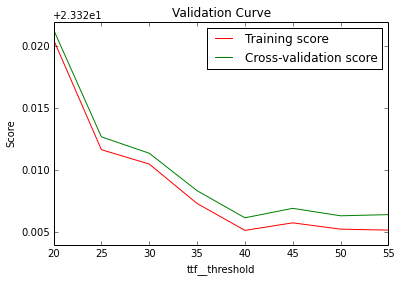

In [8]:
print pip.get_params()['steps']
print train_scores_mean
print test_scores_mean
# Plotting the validation curver, i.e. trn/val error versus parameter value
plt.title("Validation Curve")
plt.xlabel(param_name)
plt.ylabel("Score")
plt.plot(param_range, train_scores_mean, label="Training score", color="r")
# plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="g")
# plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

[('ttf', TargetThresholdFilter(threshold=95)), ('lpo', LogPlusOne()), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('clf', XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=10, nthread=6,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1))]
[ 23.32734111  23.32517229  23.3257775   23.3252702   23.32519141
  23.3265972   23.32697535  23.32722887  23.32856829  23.329611
  23.33023189  23.33142561  23.33186614]
[ 23.32837003  23.32618436  23.32694778  23.32634706  23.32643975
  23.32782747  23.32799833  23.32834664  23.3297957   23.33087059
  23.33146931  23.3325642   23.33304502]


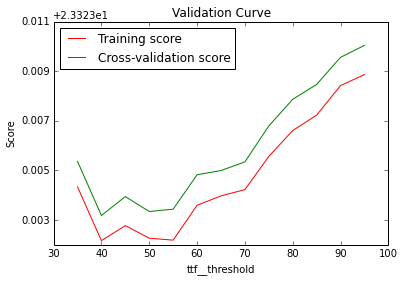

In [10]:
print pip.get_params()['steps']
print train_scores_mean
print test_scores_mean
# Plotting the validation curver, i.e. trn/val error versus parameter value
plt.title("Validation Curve")
plt.xlabel(param_name)
plt.ylabel("Score")
plt.plot(param_range, train_scores_mean, label="Training score", color="r")
# plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="g")
# plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

[('ttf', TargetThresholdFilter(threshold=59)), ('lpo', LogPlusOne()), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('clf', XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=10, nthread=6,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1))]
[35 37 39 41 43 45 47 49 51 53 55 57 59]
[ 23.32734111  23.32648336  23.32563079  23.32481212  23.32435456
  23.3257775   23.32576055  23.32539407  23.32558056  23.32546596
  23.32519141  23.32509582  23.3264783 ]
[ 23.32837003  23.32755282  23.32663944  23.32584383  23.32530818
  23.32694778  23.32683543  23.32658774  23.32676298  23.32670598
  23.32643975  23.32635231  23.32775549]


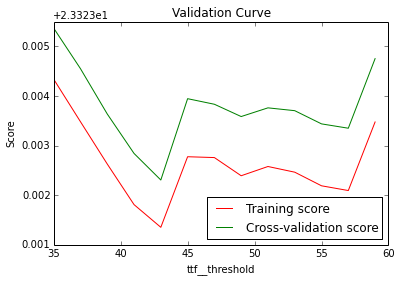

In [18]:
print pip.get_params()['steps']
print param_range
print train_scores_mean
print test_scores_mean
# Plotting the validation curver, i.e. trn/val error versus parameter value
plt.title("Validation Curve")
plt.xlabel(param_name)
plt.ylabel("Score")
plt.plot(param_range, train_scores_mean, label="Training score", color="r")
# plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="g")
# plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

# Generate submission

In [9]:
pip.fit(X, y)

Pipeline(steps=[('ttf', <cleaning.TargetThresholdFilter object at 0x7f846dca14d0>), ('lpo', <cleaning.LogPlusOne object at 0x7f846dca18d0>), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('clf',...egression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
         blending_split=10))])

In [10]:
test = pd.read_csv('../data/test.csv')
test_withRef = test[test['Ref'].notnull()]
test_withRef_comb = test_withRef.groupby('Id').agg(['mean','std','median','count','min', 'max'])
test_withRef_comb.columns = ['_'.join(tup) for (i,tup) in enumerate(test_withRef_comb.columns.values)]
test_X = test_withRef_comb.loc[:, 'minutes_past_mean':'Kdp_5x5_90th_max']  # NOTE: used range slicing on column
test_y_predict = 10**pip.predict(X=test_X)-1

In [11]:
# Ref-samples
test_result_withRef = pd.DataFrame()
test_result_withRef['Id'] = test_withRef_comb.index
test_result_withRef['Expected'] = test_y_predict
# All-samples
test_result = pd.DataFrame()
test_result['Id'] = test['Id'].unique()
# Merge and set Non-Ref samples to -1
test_result = pd.merge(test_result, test_result_withRef, how='left', on=['Id'], sort=True)
test_result.loc[test_result['Expected'].isnull(), 'Expected'] = -1
# Write file
datetime_str = time.strftime('%Y%m%d_%H%M%S')
test_result.to_csv('../data/result_'+datetime_str+'.csv', index=False)
print '../data/result_'+datetime_str+'.csv'

../data/result_20151122_015933.csv
